In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [12]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [15]:
# reflect an existing database into a new model
Base = automap_base()


# reflect the tables
Base.prepare(autoload_with=engine)


In [16]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [17]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [18]:
# Create our session (link) from Python to the DB
session = Session(engine)


In [42]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Precipitation Analysis

In [28]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]


<function matplotlib.pyplot.show(close=None, block=None)>

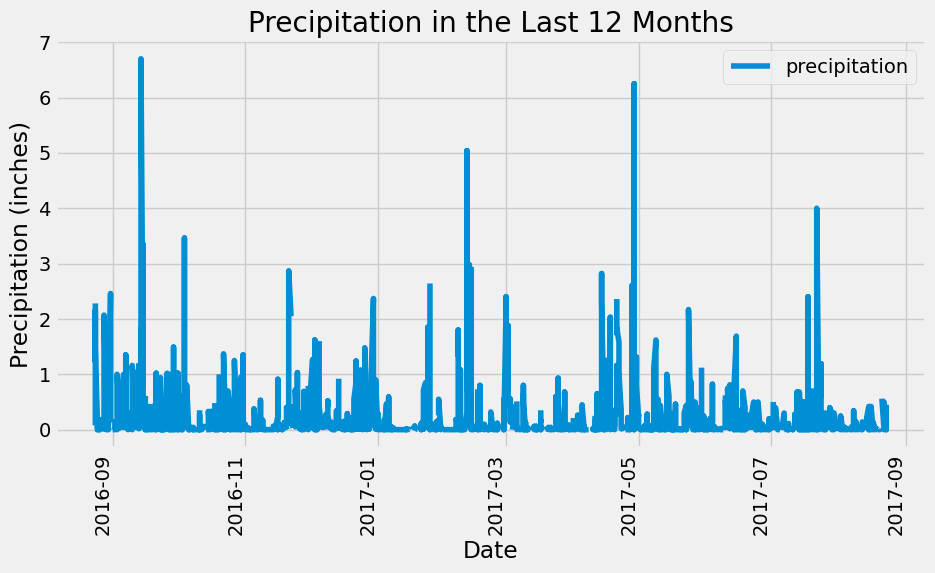

In [34]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_datetime = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')


# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_datetime - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(precip_data, columns=['date', 'precipitation'])


# Sort the dataframe by date
precip_df['date'] = pd.to_datetime(precip_df['date'])  # Convert 'date' to datetime
precip_df.sort_values(by='date', inplace=True)
precip_df.set_index('date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(figsize=(10,6), rot=90)
plt.title("Precipitation in the Last 12 Months")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.show

In [36]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_summary = precip_df['precipitation'].describe().to_frame()
precip_summary


,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [38]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).first()
total_stations

(9,)

In [41]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
active_stations[0]

('USC00519281', 2772)

In [44]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]
temperature_stats = session.query(
    func.min(Measurement.tobs), 
    func.max(Measurement.tobs), 
    func.avg(Measurement.tobs)
).filter(Measurement.station == most_active_station).all()
temperature_stats


[(54.0, 85.0, 71.66378066378067)]

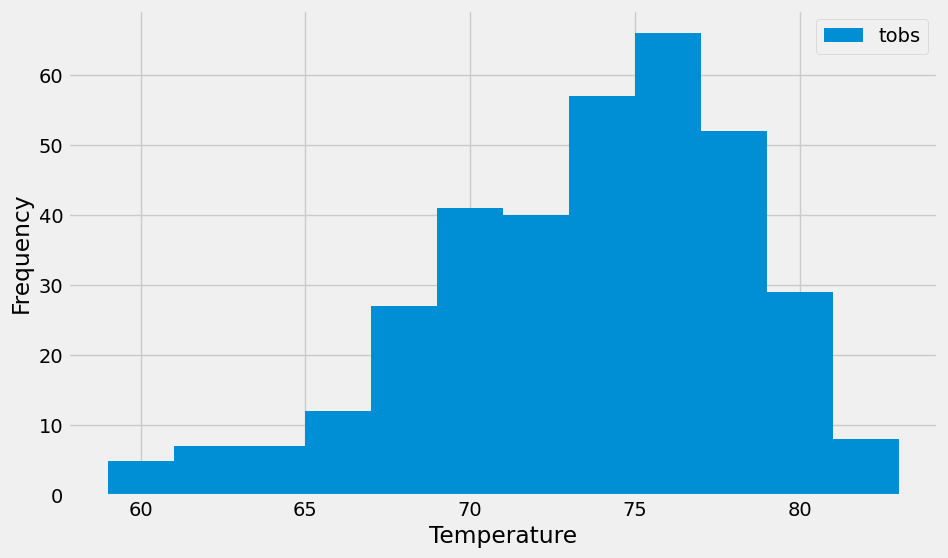

In [53]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()
temperatures = [temp[0] for temp in temperature_data]

# plot results
plt.figure(figsize=(10, 6))
plt.hist(temperatures, bins=12, label='tobs')
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(title="")
plt.show()

# Close Session

In [54]:
# Close Session
session.close()